## Imports

In [9]:
from skorch import NeuralNetRegressor
from skorch.callbacks import Checkpoint, EarlyStopping

import torch
import torch.nn as nn

import numpy as np

import os

from TurbulenceNetwork import TurbulenceNetwork
from TurbulenceClosureDataGenerator import TurbulenceClosureDataGenerator
from plot_utils import plot_data_generation_diff, plot_heat_map

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


## Misc Utilities

In [6]:
class MAPELoss:
    def __init__(self, *args, **kwargs):
        self.eta = 1e-5
        pass

    def __call__(self, y_pred, y_true):
        l = torch.abs((y_true - y_pred)) / (torch.abs(y_true)) * 100

        return torch.mean(l)


## Data Generation

/home/codygrogan/PythonProjects/Uncertainty_Quantification/TurbulenceClosureDataGenerator.py:85: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos((-b/2)*np.sqrt(-a**3/27))


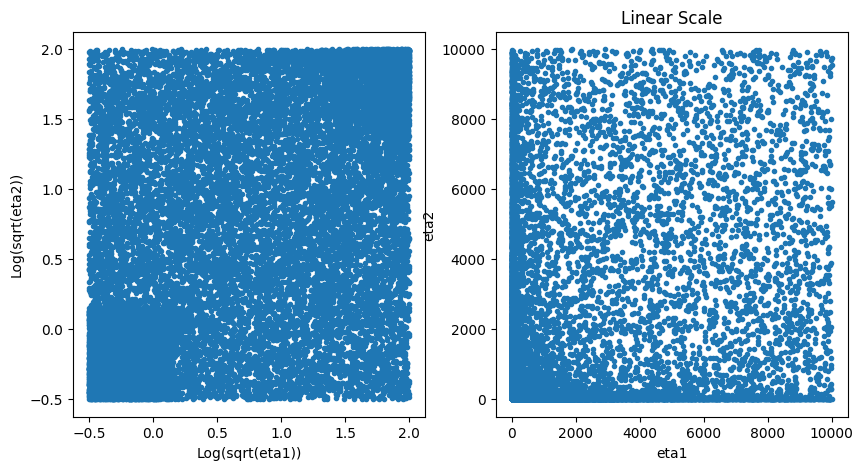

In [7]:
LLR_gen = TurbulenceClosureDataGenerator('LRR')
SSG_gen = TurbulenceClosureDataGenerator('SSG')
SZL_gen = TurbulenceClosureDataGenerator('SZL')

log_narrow = (-.5, .15)
log = (-.5, 2)
lin = (.1, 10_000)

# Generating data on a narrowed log scale
LLR_x_log_narrow, LLR_y_log_narrow = LLR_gen((10**np.random.uniform(*log_narrow, 10))**2, (10**np.random.uniform(*log_narrow, 10))**2)
SSG_x_log_narrow, SSG_y_log_narrow = SSG_gen((10**np.random.uniform(*log_narrow, 10_000))**2, (10**np.random.uniform(*log_narrow, 10_000))**2)
SZL_x_log_narrow, SZL_y_log_narrow = SZL_gen((10**np.random.uniform(*log_narrow, 10))**2, (10**np.random.uniform(*log_narrow, 10))**2)

# Generating data on a log scale
LLR_x_log, LLR_y_log = LLR_gen((10**np.random.uniform(*log, 10))**2, (10**np.random.uniform(*log, 10))**2)
SSG_x_log, SSG_y_log = SSG_gen((10**np.random.uniform(*log, 14_000))**2, (10**np.random.uniform(*log, 14_000))**2)
SZL_x_log, SZL_y_log = SZL_gen((10**np.random.uniform(*log, 10))**2, (10**np.random.uniform(*log, 10))**2)

# Generating data on a linear scale
LLR_x_lin, LLR_y_lin = LLR_gen(np.random.uniform(*lin, 10), np.random.uniform(*lin, 10))
SSG_x_lin, SSG_y_lin = SSG_gen(np.random.uniform(*lin, 3_000), np.random.uniform(*lin, 3_000))
SZL_x_lin, SZL_y_lin = SZL_gen(np.random.uniform(*lin, 10), np.random.uniform(*lin, 10))

x = np.concatenate((
    LLR_x_log_narrow, SSG_x_log_narrow, SZL_x_log_narrow,
    LLR_x_log, SSG_x_log, SZL_x_log,
    SSG_x_lin, LLR_x_lin, SZL_x_lin
    ))
y = np.concatenate((
    LLR_y_log_narrow, SSG_y_log_narrow, SZL_y_log_narrow,
    LLR_y_log, SSG_y_log, SZL_y_log,
    SSG_y_lin, LLR_y_lin, SZL_y_lin
    ))

plot_data_generation_diff(np.log10(np.sqrt(x)))

total = np.concatenate((x, y), axis=1)

np.random.shuffle(total)

x = total[:, :2]
y = total[:, 2:]

x_test_LLR , y_test_LLR = LLR_gen(np.random.uniform(.1, 10_000, 1_000), np.random.uniform(.1, 10_000, 1_000))
x_test_SSG , y_test_SSG = SSG_gen(np.random.uniform(.1, 10_000, 1_000), np.random.uniform(.1, 10_000, 1_000))
x_test_SZL , y_test_SZL = SZL_gen(np.random.uniform(.1, 10_000, 1_000), np.random.uniform(.1, 10_000, 1_000))

x_test = np.concatenate((x_test_LLR, x_test_SSG, x_test_SZL))
y_test = np.concatenate((y_test_LLR, y_test_SSG, y_test_SZL))


## Network Training

In [11]:
callbacks = [EarlyStopping(patience=10, monitor='valid_loss', lower_is_better=True),
            Checkpoint(monitor='valid_loss_best', f_params='TurbulenceNetwork.pt', dirname='./Model_Checkpoints/')
]

model = TurbulenceNetwork(input_dim=2, output_dim=3, num_layers=7, nodes=[7, 7, 7, 7, 7, 7, 7])
criterion = nn.L1Loss
optimizer = torch.optim.Adam

net = NeuralNetRegressor(   
        module=model,
        criterion=criterion,
        optimizer=optimizer,
        lr=0.0001,
        batch_size=64,
        max_epochs=400,
        device=device,
        iterator_train__shuffle=True,
        iterator_train__num_workers=4,
        iterator_train__pin_memory=True,
        iterator_valid__shuffle=False,
        iterator_valid__num_workers=4,
        iterator_valid__pin_memory=True,
        callbacks=callbacks,
)

net = net.fit(x, y)



  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        1.2414        0.4633     +  0.5864
      2        0.2119        0.1226     +  0.5916
      3        0.0996        0.0842     +  0.5532
      4        0.0763        0.0685     +  0.5812
      5        0.0636        0.0591     +  0.5897
      6        0.0552        0.0509     +  0.5879
      7        0.0464        0.0415     +  0.5896
      8        0.0382        0.0346     +  0.5885
      9        0.0321        0.0295     +  0.5979
     10        0.0278        0.0258     +  0.5683
     11        0.0246        0.0228     +  0.5693
     12        0.0218        0.0205     +  0.5974
     13        0.0197        0.0187     +  0.6150
     14        0.0181        0.0172     +  0.5741
     15        0.0166        0.0160     +  0.5709
     16        0.0154        0.0149     +  0.6072
     17        0.0144        0.0140     +  0.5853
     18        0.0135        0.0133     +  0.5798


## Plotting Model Statistics

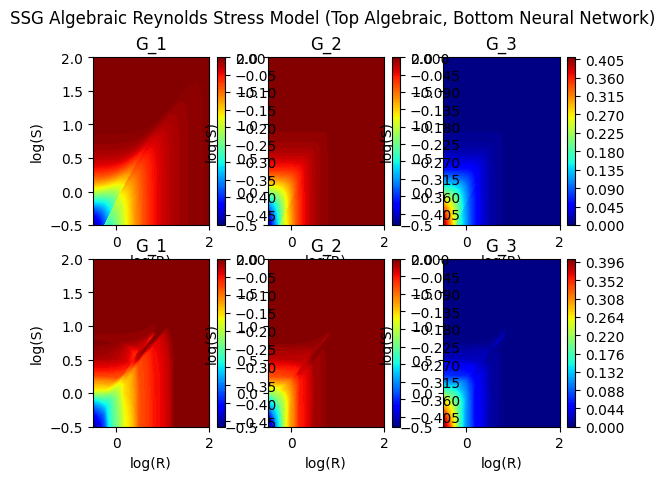

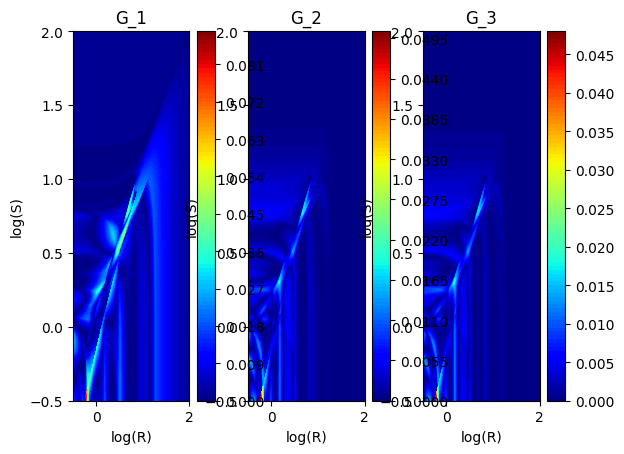

In [14]:
checkpoint_dir = './Model_Checkpoints'

net = NeuralNetRegressor(
    module=model,
    criterion=criterion,
    optimizer=optimizer
)

net.initialize()
net.load_params(f_params=os.path.join(checkpoint_dir,'TurbulenceNetwork.pt'),
                f_optimizer=os.path.join(checkpoint_dir, 'optimizer.pt'),
                f_criterion=os.path.join(checkpoint_dir, 'criterion.pt'),
                f_history=os.path.join(checkpoint_dir, 'history.json')
)

plot_heat_map(net)